In [1]:
import os
import pandas as pd
import numpy as np
import copy
import seaborn as sns

from collections import Counter
from imblearn.over_sampling import ADASYN

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

from rdkit import RDLogger  
RDLogger.DisableLog('rdApp.*') 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics

from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

print(rdkit.__version__)

2021.03.2


In [2]:
#loading csv's:

data_train = pd.read_csv("data_train.csv",index_col=0).reset_index(drop=True)
smiles_test = pd.read_csv("smiles_test.csv",index_col=0).reset_index(drop=True)
sample_sub = pd.read_csv("sample_submission.csv",index_col=0).reset_index(drop=True)

In [3]:
data_train

,smiles,task1,task2,task3,task4,task5,task6,task7,task8,task9,task10,task11
0,CC(=O)N(C)c1cccc(-c2ccnc3c(C(=O)c4cccs4)cnn23)c1,0,0,0,0,0,0,0,-1,0,0,0
1,COc1cc(N)c(Cl)cc1C(=O)OCCCN1CCCCC1.Cl,0,0,0,0,0,0,0,-1,0,0,0
2,CCCCNc1c(C(=O)OCC)cnc2c1cnn2CC,0,0,0,0,0,0,0,0,0,1,0
3,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1.Cl,0,0,0,0,0,0,0,-1,0,0,1
4,CC1OC2(CCCCC2Oc2cccc(Cl)c2)N=C1O,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11995,CC(C)(C)NC[C@@H](O)COc1nsnc1N1CCOCC1,0,0,0,0,0,0,0,-1,0,0,0
11996,CCC[C@@]1(CCc2ccccc2)CC(O)=C([C@H](CC)c2cccc(N...,0,0,0,0,0,0,0,-1,0,0,0
11997,N=C(O)c1cnc(C2CC2)[nH]1,0,0,0,-1,0,0,0,0,0,0,0
11998,CN=C=O,0,0,0,0,0,0,-1,0,0,0,0


In [4]:
smiles_test

,smiles
0,OC(COc1ccc(Cl)cc1)=N[C@H]1CC[C@H](N=C(O)COc2cc...
1,CCCO/N=C(/C)c1cc(C(O)=NC(Cc2cc(F)cc(F)c2)[C@@H...
2,COc1cc(Cl)ccc1Cl
3,COc1cc(C(O)=NCc2ccc(OCCN(C)C)cc2)cc(OC)c1OC
4,CCC(=O)O[C@@]1(C(=O)CCl)[C@@H](C)C[C@H]2[C@@H]...
...,...
5891,N#Cc1cc(NC(=O)C(=O)O)c(Cl)c(NC(=O)C(=O)O)c1.NC...
5892,O=c1cccc2n1C[C@@H]1CNC[C@H]2C1
5893,CSCC[C@H](N=C(O)[C@H](Cc1ccccc1)N=C(O)CN=C(O)C...
5894,CCn1cc2c3c(cc(C(O)=NC(Cc4ccccc4)[C@H](O)C[NH2+...


In [5]:
sample_sub

,task1,task2,task3,task4,task5,task6,task7,task8,task9,task10,task11
0,0.965388,0.669021,0.364129,0.248534,0.082723,0.101662,0.894853,0.099291,0.931158,0.132221,0.617906
1,0.972610,0.986971,0.060073,0.286885,0.865854,0.805776,0.481583,0.715330,0.388927,0.998184,0.378946
2,0.366591,0.275695,0.063553,0.966171,0.442205,0.969089,0.509688,0.540241,0.441256,0.164225,0.070570
3,0.475604,0.490168,0.755998,0.477857,0.371955,0.947405,0.280805,0.872361,0.513712,0.570384,0.990165
4,0.034529,0.669413,0.480047,0.011377,0.747641,0.272674,0.322530,0.330088,0.929216,0.492997,0.496907
...,...,...,...,...,...,...,...,...,...,...,...
5891,0.841416,0.832933,0.144299,0.092632,0.860756,0.797975,0.407141,0.819184,0.808753,0.693338,0.253581
5892,0.634844,0.643848,0.698586,0.211566,0.791034,0.462967,0.498234,0.265715,0.171268,0.524664,0.046151
5893,0.161446,0.419693,0.310739,0.977375,0.632457,0.645635,0.952371,0.000913,0.391865,0.986964,0.953342
5894,0.630445,0.798230,0.842443,0.188696,0.407885,0.308575,0.523217,0.240382,0.564827,0.343042,0.005972


In [6]:
data_train.shape

(12000, 12)

In [7]:
smiles_test.shape

(5896, 1)

In [8]:
#check for NaN-values:

data_train.isnull().values.any()

False

In [9]:
#calculate morgan fingerprints on smiles of data_train:

# Initialize variables
fp_length = 420
fps = np.zeros((len(data_train), fp_length))

# Calculate Morgan fingerprints and convert to numpy array
for i, smiles in enumerate(tqdm(data_train['smiles'])):
    mol = Chem.MolFromSmiles(smiles)
    fp_vec = AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=fp_length)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp_vec, arr)
    fps[i] = arr

100%|██████████████████████████████████████████████████████████████████████████| 12000/12000 [00:05<00:00, 2088.59it/s]


In [10]:
pd.DataFrame(fps)

,0,1,2,3,4,5,6,7,8,9,...,410,411,412,413,414,415,416,417,418,419
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11996,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
11997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
11998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [11]:
fps.shape

(12000, 420)

In [12]:
#calculate morgan fingerprints on smiles of test:

# Initialize variables
fp_length = 420
fps_test = np.zeros((len(data_train), fp_length))

# Calculate Morgan fingerprints and convert to numpy array
for i, smiles in enumerate(tqdm(smiles_test['smiles'])):
    mol = Chem.MolFromSmiles(smiles)
    fp_vec = AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=fp_length)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp_vec, arr)
    fps_test[i] = arr

100%|████████████████████████████████████████████████████████████████████████████| 5896/5896 [00:02<00:00, 2106.94it/s]


In [13]:
pd.DataFrame(fps_test)

,0,1,2,3,4,5,6,7,8,9,...,410,411,412,413,414,415,416,417,418,419
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
#https://medium.com/@gurkamaldeol/predicting-environmental-carcinogens-with-logistic-regression-knn-gradient-boosting-and-7973f88eb8b3

In [15]:
y = data_train[data_train.columns[1:]]
y = y.to_numpy()
y.shape

(12000, 11)

In [16]:
#consider fps as X (= Dataset) and y as the predictions

In [17]:
#how balanced is the dataset?

unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{-1: 15179, 0: 113123, 1: 3698}

In [18]:
overall = 3698+15179
overall

18877

In [19]:
active_per = 3698*100 / 18877
active_per

19.58997722095672

In [20]:
inactive_per = 15179*100 / 18877
inactive_per

80.41002277904327

In [21]:
print(y[:, 0])

[0 0 0 ... 0 0 0]


In [22]:
#probably write a function for that!

y_task1 = data_train[data_train.columns[1]].to_numpy()
y_task2 = data_train[data_train.columns[2]].to_numpy()
y_task3 = data_train[data_train.columns[3]].to_numpy()
y_task4 = data_train[data_train.columns[4]].to_numpy()
y_task5 = data_train[data_train.columns[5]].to_numpy()
y_task6 = data_train[data_train.columns[6]].to_numpy()
y_task7 = data_train[data_train.columns[7]].to_numpy()
y_task8 = data_train[data_train.columns[8]].to_numpy()
y_task9 = data_train[data_train.columns[9]].to_numpy()
y_task10 = data_train[data_train.columns[10]].to_numpy()
y_task11 = data_train[data_train.columns[11]].to_numpy()
y_task1

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [23]:
#Applying the ADASYN algorithm (since only y with as 1d-array is allowed try with task1 first)
#probably write a function for that!

#1:
fps_rsmp1, y_rsmp1 = ADASYN().fit_resample(fps, y_task1 )
sample_count = sorted(Counter(y_rsmp1).items())

#2:
fps_rsmp2, y_rsmp2 = ADASYN().fit_resample(fps, y_task2)
sample_count = sorted(Counter(y_rsmp2).items())

#3:
fps_rsmp3, y_rsmp3 = ADASYN().fit_resample(fps, y_task3)
sample_count = sorted(Counter(y_rsmp3).items())

#4:
fps_rsmp4, y_rsmp4 = ADASYN().fit_resample(fps, y_task4)
sample_count = sorted(Counter(y_rsmp4).items())

#5:
fps_rsmp5, y_rsmp5 = ADASYN().fit_resample(fps, y_task5)
sample_count = sorted(Counter(y_rsmp5).items())

#6:
fps_rsmp6, y_rsmp6 = ADASYN().fit_resample(fps, y_task6)
sample_count = sorted(Counter(y_rsmp6).items())

#7:
fps_rsmp7, y_rsmp7 = ADASYN().fit_resample(fps, y_task7)
sample_count = sorted(Counter(y_rsmp7).items())

#8:
fps_rsmp8, y_rsmp8 = ADASYN().fit_resample(fps, y_task8)
sample_count = sorted(Counter(y_rsmp8).items())

#9:
fps_rsmp9, y_rsmp9 = ADASYN().fit_resample(fps, y_task9)
sample_count = sorted(Counter(y_rsmp9).items())

#10:
fps_rsmp10, y_rsmp10 = ADASYN().fit_resample(fps, y_task10)
sample_count = sorted(Counter(y_rsmp10).items())

#11:
fps_rsmp11, y_rsmp11 = ADASYN().fit_resample(fps, y_task11)
sample_count = sorted(Counter(y_rsmp11).items())

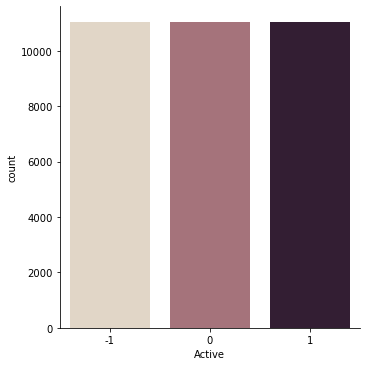

In [24]:
y_rsmp11_df = pd.DataFrame(y_rsmp11, columns=['Active'])
sns.catplot(x="Active", kind="count", palette="ch:.25", data=y_rsmp11_df);

In [25]:
y_rsmp1.shape


(32951,)

In [26]:
fps_rsmp1.shape

(32951, 420)

# do the same for the whole y-dataset:


In [27]:
def resample(X,y):
    
    fps_rsmp_sets = []
    y_j_list=[]

    for j in range(y.shape[1]):
        fps_j, y_j = ADASYN().fit_resample(X, y[:,j] )
        sample_count = sorted(Counter(y_j).items())
        fps_rsmp_sets.append(fps_j)
        y_j_list.append(y_j)
        
    return fps_rsmp_sets, y_j_list


# does not work since every column of the resulting y_rsmp array would have a different shape

In [28]:
fps_rsmp_sets, y_j_list = resample(fps,y)

In [29]:
for i, j in zip(fps_rsmp_sets, y_j_list):
    print(i.shape, j.shape)

#for i in y_j_list:
    #print(i.shape)
    
#for i in fps_rsmp_sets:
#   print(i.shape)

#print(len(fps_rsmp_sets),len(y_j_list))

#y_j_list[0].shape

(32951, 420) (32951,)
(34051, 420) (34051,)
(33153, 420) (33153,)
(34230, 420) (34230,)
(34252, 420) (34252,)
(32712, 420) (32712,)
(23391, 420) (23391,)
(24717, 420) (24717,)
(25455, 420) (25455,)
(32006, 420) (32006,)
(33112, 420) (33112,)


# Train and Test split

In [30]:
#might be unnecessary ( isn't that exactly what train_test_split does?)

def split_data(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    return X_train, X_test, y_train, y_test

# Define Logistic Regression Model

In [31]:
#https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

In [32]:
def logreg(X_train, X_test, y_train, y_test):
    
    #define and train:
    logreg = LogisticRegression(solver = 'lbfgs', max_iter = 800)
    LogisticRegressionCV(cv=10, solver = 'lbfgs', max_iter = 800, multi_class = "ovr", n_jobs = 4).fit(x_train, y_train)
    
    #predict and print accuracy:
    y_pred = logreg.predict(X_test)
    print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
    print(classification_report(y_test, y_pred))

In [33]:
#testing with fps_sets[0] and y_j[0]:


for i,j in zip(fps_rsmp_sets,y_j_list):
    
    #split:
    X_train, X_test, y_train, y_test = train_test_split(i, j, test_size=0.2)

    #train and evaluate:

    print(logreg(X_train, X_test, y_train, y_test))
    

NameError: name 'x_train' is not defined

# Logistic Regression without oversampling: 

In [48]:
def train_logreg(X_train, y_train, X_test):
    n_tasks = y_train.shape[1]
    y_hats_proba = np.empty((X_test.shape[0], n_tasks))
    y_hats_class = np.empty_like(y_hats_proba)
    
    # Train RF per task
    for j in tqdm(range(n_tasks)):
        logreg = LogisticRegressionCV(cv=10, solver = 'lbfgs', max_iter = 1000)
        # Mask out unknown samples
        idx = (y_train[:, j] != (0))
        # Train model
        logreg.fit(X_train[idx], y_train[idx, j])
        # Predict class probabilities (select only values for positiv class with index 1)
        y_hats_proba[:, j] = logreg.predict_proba(X_test)[:, 1]
        # Predict class 
        y_hats_class[:, j] = logreg.predict(X_test)
    return y_hats_proba, y_hats_class 

In [49]:
X_train, X_test, y_train, y_test = split_data(fps,y)

y_hats_proba, y_hats_class = train_logreg(X_train, y_train, X_test)


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:42<00:00,  3.91s/it]


In [50]:
unique, counts = np.unique(y_hats_class, return_counts=True)
dict(zip(unique, counts))

{-1.0: 20115, 1.0: 6285}

In [51]:
task = 1
# Mask out unknown samples
idx = (y_test[:, task] != (0))

In [52]:
cm = confusion_matrix(y_test[idx,task], y_hats_class[idx,task])
cm

array([[28, 40],
       [29, 39]], dtype=int64)

In [53]:
cm.ravel()

array([28, 40, 29, 39], dtype=int64)

In [54]:
print(classification_report(y_test[idx,task],y_hats_class[idx,task], target_names=["class -1", "class 1"]))

              precision    recall  f1-score   support

    class -1       0.49      0.41      0.45        68
     class 1       0.49      0.57      0.53        68

    accuracy                           0.49       136
   macro avg       0.49      0.49      0.49       136
weighted avg       0.49      0.49      0.49       136



In [55]:
def calc_masked_AUC_per_task(prediction, target):
    auc_per_task = []
    for j in range(target.shape[1]):
        y_score = prediction[:, j]
        y_true = target[:, j]
        # Mask out unknown samples
        idx = (y_true != (-1))
        # Calculate AUC per task
        auc_per_task.append(roc_auc_score(y_true[idx], y_score[idx]))
    return auc_per_task

In [56]:
# Calculate AUC per task
auc_per_task = calc_masked_AUC_per_task(y_hats_proba, y_test)
auc_per_task

[0.9459137754384555,
 0.5624512835169403,
 0.5893621679888165,
 0.8593111500291885,
 0.568749182044235,
 0.6169276132729766,
 0.5019264488741233,
 0.7017893660531698,
 0.6970849056603773,
 0.6742283964659102,
 0.776399886877828]

In [57]:
np.mean(auc_per_task)

0.6812858342020018

# Define Random Forrest

In [38]:
def train_rf(X_train, y_train, X_test):
    seed = 1234
    n_tasks = y_train.shape[1]
    y_hats_proba = np.empty((X_test.shape[0], n_tasks))
    y_hats_class = np.empty_like(y_hats_proba)
    
    # Train RF per task
    for j in tqdm(range(n_tasks)):
        rf_model = RandomForestClassifier(n_estimators=100, random_state=seed)
        # Mask out unknown samples
        idx = (y_train[:, j] != (0))
        # Train model
        rf_model.fit(X_train[idx], y_train[idx, j])
        # Predict class probabilities (select only values for positiv class with index 1)
        y_hats_proba[:, j] = rf_model.predict_proba(X_test)[:, 1]
        # Predict class 
        y_hats_class[:, j] = rf_model.predict(X_test)
    return y_hats_proba, y_hats_class 

In [39]:
X_train, X_test, y_train, y_test = split_data(fps,y)

y_hats_proba, y_hats_class = train_rf(X_train, y_train, X_test)


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.16it/s]


In [40]:
unique, counts = np.unique(y_hats_class, return_counts=True)
dict(zip(unique, counts))

{-1.0: 20693, 1.0: 5707}

In [41]:
task = 0
# Mask out unknown samples
idx = (y_test[:, task] != (0))

In [42]:
cm = confusion_matrix(y_test[idx,task], y_hats_class[idx,task])
cm

array([[99, 19],
       [27, 55]], dtype=int64)

In [43]:
cm.ravel()

array([99, 19, 27, 55], dtype=int64)

In [44]:
print(classification_report(y_test[idx,task],y_hats_class[idx,task], target_names=["class -1", "class 1"]))

              precision    recall  f1-score   support

    class -1       0.79      0.84      0.81       118
     class 1       0.74      0.67      0.71        82

    accuracy                           0.77       200
   macro avg       0.76      0.75      0.76       200
weighted avg       0.77      0.77      0.77       200



In [45]:
def calc_masked_AUC_per_task(prediction, target):
    auc_per_task = []
    for j in range(target.shape[1]):
        y_score = prediction[:, j]
        y_true = target[:, j]
        # Mask out unknown samples
        idx = (y_true != (-1))
        # Calculate AUC per task
        auc_per_task.append(roc_auc_score(y_true[idx], y_score[idx]))
    return auc_per_task

In [46]:
# Calculate AUC per task
auc_per_task = calc_masked_AUC_per_task(y_hats_proba, y_test)
auc_per_task

[0.920049889135255,
 0.5831159034982503,
 0.5585249994259038,
 0.7322564721369021,
 0.7140833266820975,
 0.5638364386644991,
 0.5835859110853366,
 0.752123786407767,
 0.5889303131296014,
 0.6831869856037875,
 0.7520899351139279]

In [47]:
np.mean(auc_per_task)

0.6756167237166661